 ## 1. 关于C-N交叉偶联反应产率预测案例（基于Ahneman et al., Science 2018）

In [7]:
## 数据相关模块
import pandas as pd
import numpy as np 

## 模型相关
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

## 模型解释
import shap

## 图形可视化
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
1. ##导入数据


data = pd.read_csv('./model_data.csv')

In [3]:
2. ## 按照70/30数据分割数据集——训练集、测试集
train_data, test_data = train_test_split(data,test_size=0.3, random_state=2025)

In [8]:
3. ##建立模型并预测测试集

RF = RandomForestRegressor()  #实例化模型
RF.fit(train_data.iloc[:,1:], train_data.iloc[:, 0]) #训练模型
test = RF.predict(test_data.iloc[:,1:]) # 预测，模型
print('模型在测试集上的rmse：', root_mean_squared_error(test_data.iloc[:, 0], test))  #在测试集上评估模型
print('模型在测试集上的r2：', r2_score(test_data.iloc[:, 0], test))

模型在测试集上的rmse： 7.608240110405561
模型在测试集上的r2： 0.9193173445664686


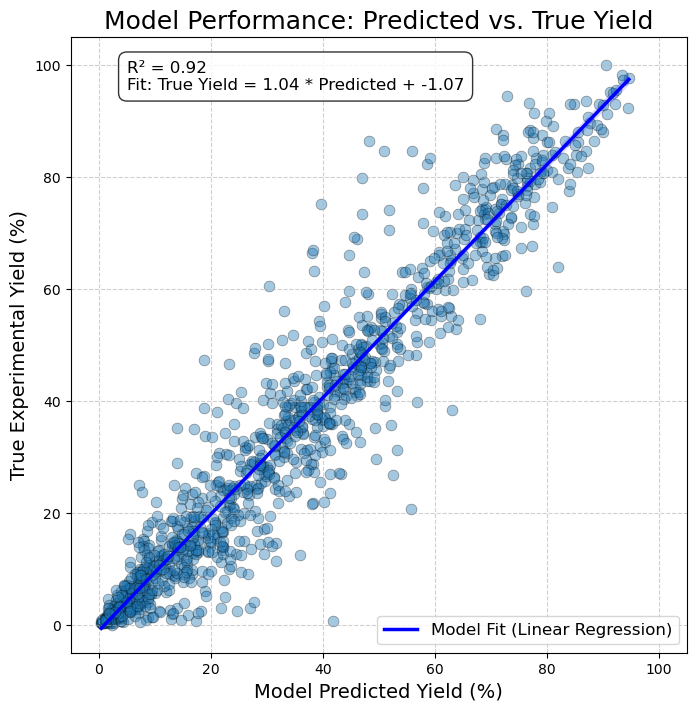

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import linregress

# --- 准备数据 ---
results_df = pd.DataFrame({
    'True Yield': test_data.iloc[:, 0],
    'Predicted Yield': test
})
# --- 计算关键指标 ---
# 注意：根据图中坐标轴，x是'Predicted Yield', y是'True Yield'
x_vals = results_df['Predicted Yield']
y_vals = results_df['True Yield']

# 计算 R²
r2 = r2_score(y_vals, x_vals) # 注意sklearn的r2_score顺序是(y_true, y_pred)

# 计算线性回归方程的斜率(m)和截距(b)
slope, intercept, _, _, _ = linregress(x_vals, y_vals)

# --- 开始绘图 ---
plt.figure(figsize=(10, 8))

sns.regplot(x='Predicted Yield', y='True Yield', data=results_df, 
            scatter_kws={'alpha':0.4, 's':60, 'edgecolor':'black', 'linewidths':0.5},
            line_kws={'color': 'blue', 'linewidth': 2.5, 'label': 'Model Fit (Linear Regression)'})

# --- 在图上添加文本 ---
# 创建文本内容
stats_text = (f'R² = {r2:.2f}\n'
              f'Fit: True Yield = {slope:.2f} * Predicted + {intercept:.2f}')
# 将文本放置在左上角
plt.text(5, 95, stats_text, 
         fontsize=12, 
         ha='left', 
         va='bottom',
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

# --- 图表美化 ---
plt.title('Model Performance: Predicted vs. True Yield', fontsize=18)
plt.xlabel('Model Predicted Yield (%)', fontsize=14)
plt.ylabel('True Experimental Yield (%)', fontsize=14)
plt.xlim(-5, 105)
plt.ylim(-5, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='lower right', fontsize=12)
plt.gca().set_aspect('equal', adjustable='box') # 确保x和y轴等比例

plt.show()

In [22]:
3.1 ## 或者使用交叉验证——5折交叉验证并预测测试集
NFOLD = 5
folds = KFold(n_splits=5,shuffle=True, random_state=5)
rmse_set = []
test_set = []
for k, (train_idx, val_idx) in enumerate(folds.split(train_data)):
    train_X, val_X = train_data.iloc[train_idx, 1:], train_data.iloc[val_idx, 1:]
    train_y, val_y = train_data.iloc[train_idx, 0], train_data.iloc[val_idx, 0]

    rf = RandomForestRegressor()
    rf.fit(train_X, train_y)
    val_yield = rf.predict(val_X)
    val_rmse = root_mean_squared_error(val_y, val_yield)
    print(f'第 {k+1} 折 验证集 RMSE：', val_rmse)

    test_yield = rf.predict(test_data.iloc[:,1:])
    test_set.append(test_yield)
test_mean_yield = np.mean(test_set, axis=0)
test_rmse = root_mean_squared_error(test_data.iloc[:,0],test_mean_yield)
test_r2 = r2_score(test_data.iloc[:,0],test_mean_yield)
print('测试集的RMSE：', test_rmse)
print('测试集的R2：', test_r2)

第 1 折 验证集 RMSE： 8.83835605140902
第 2 折 验证集 RMSE： 8.36936277240741
第 3 折 验证集 RMSE： 9.419941965407757
第 4 折 验证集 RMSE： 9.080261585204127
第 5 折 验证集 RMSE： 8.52951059752494
测试集的RMSE： 7.9527992045532665
测试集的R2： 0.9118440159411989


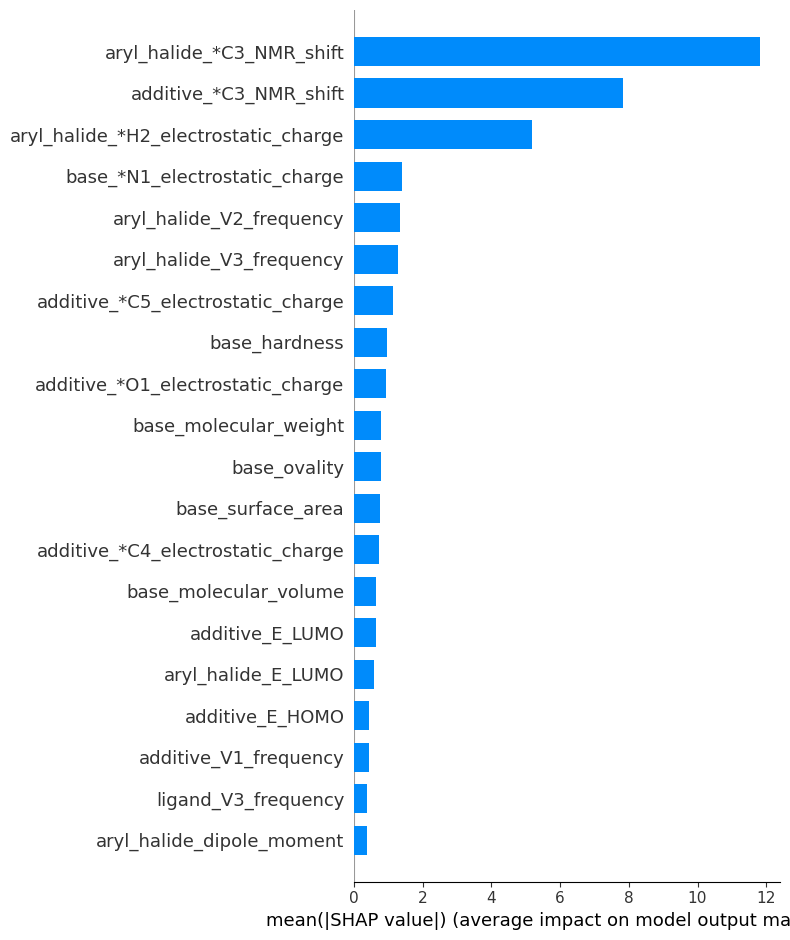

In [23]:
4. ## 模型解释 ——全局解释（柱状图）

explainer = shap.TreeExplainer(RF)  # 针对树模型（如随机森林）使用TreeExplainer
shap_values = explainer.shap_values(test_data.iloc[:, 1:])

# 绘制全局特征重要性图
shap.summary_plot(shap_values, test_data.iloc[:, 1:], plot_type="bar")

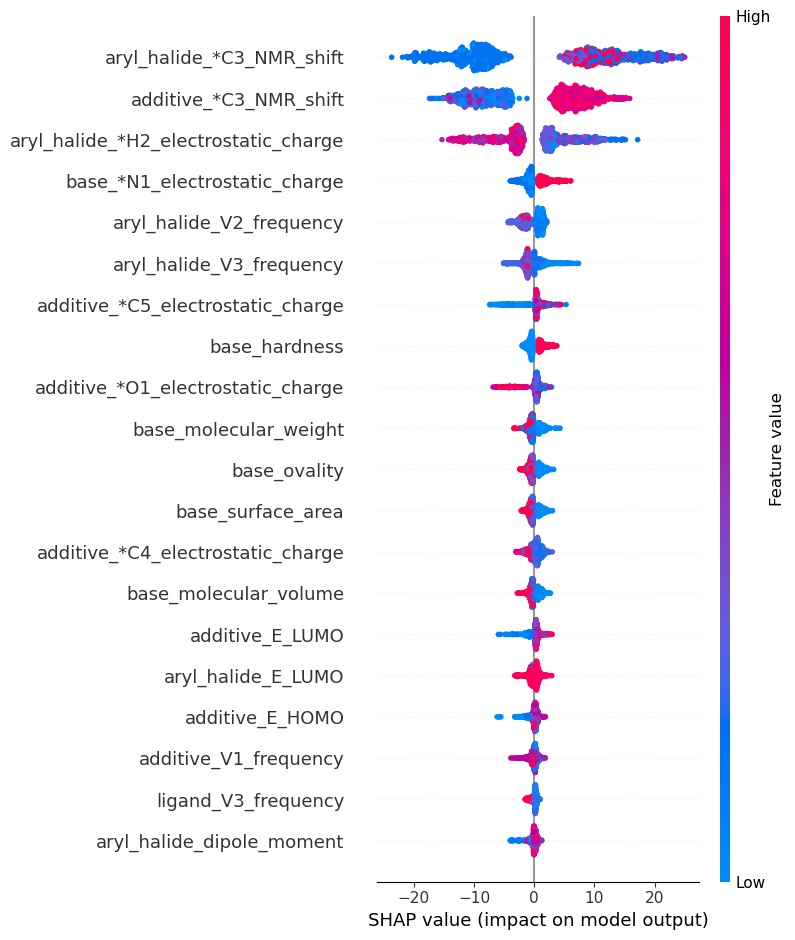

In [24]:
4. ## 模型解释 ——全局解释（散点图）
shap.summary_plot(shap_values, test_data.iloc[:, 1:])

In [27]:
4. ## 模型解释 ——针对单个反应解释
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], test_data.iloc[0, 1:])  # 产率高的样本反应

In [28]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[2,:], test_data.iloc[2, 1:])  ## 产率低的反应